# Investigating the effect of patient features by varying feature values

In this notebook we start with a 'base patient' who has features that are favourable to use of thrombolysis:

* Onset to arrival = 60 mins
* Arrival to scan = 15 mins
* Infarction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

## Observations

* There are interactions between features in the number of hopsitals that would give patients thrombolysis.
* Changing three features individually (stroke severity NIHSS=5, pre-stroke disablity =2, estimated stroke onset) have minor effects alone, but when combined only 8 out of 132 hopsitals (6.2%) are predicted to give thrombolysis to that patient.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

10k cohort of patients in test data, rest in training data

In [3]:
data_loc = '../data/10k_training_test/'

In [4]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_key_features_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_key_features_test.csv')
synthetic = pd.read_csv(data_loc + 'cohort_10000_key_features_synthetic.csv')

## Fit XGBoost model

Train a XGBoost model on the 10k cohort train/test dataset

In [5]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5\

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.846


## Predict thrombolysis with varying patient features

The base patient has the following values:

* Onset to arrival = 60 mins
* Arrival to scan = 15
* Infaction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

In [6]:
hospitals = synthetic['Stroke team']
X_synthetic = synthetic.drop('Thrombolysis', axis=1)
y_synthetic = synthetic['Thrombolysis']
X_synthetic_hosp = pd.get_dummies(X_synthetic['Stroke team'], prefix = 'team')
X_synthetic = pd.concat([X_synthetic, X_synthetic_hosp], axis=1)
X_synthetic.drop('Stroke team', axis=1, inplace=True) 


In [7]:
# Adjust NIHSS
number_thrombolysing_NIHSS = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_NIHSS.append(y_pred.sum())

# Adjust Prior disability
number_thrombolysing_mrs = []
for mrs in range(6):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = mrs
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_mrs.append(y_pred.sum())

# Adjust precise onset time
number_thrombolysing_precise_onset = []
for precise_onset in [0,1]:
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = precise_onset
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_precise_onset.append(y_pred.sum())



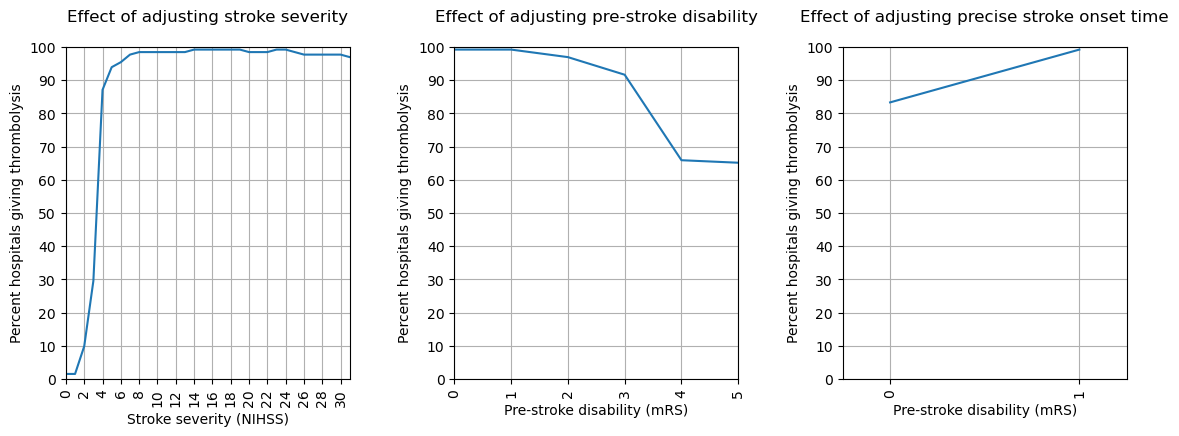

In [8]:
fig = plt.figure(figsize=(12,5))
number_hopsitals = len(hospitals)


ax1 = fig.add_subplot(1,3,1)
x1 = range(len(number_thrombolysing_NIHSS))
y1 = (np.array(number_thrombolysing_NIHSS) / number_hopsitals) * 100
ax1.plot(x1, y1)
ax1.set_xlabel('Stroke severity (NIHSS)')
ax1.set_ylabel('Percent hospitals giving thrombolysis')
ax1.set_xticks(np.arange(0,31,2))
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)
ax1.set_yticks(np.arange(0,101,10))
ax1.set_ylim(0,100)
ax1.set_xlim(0,31)
ax1.set_title('Effect of adjusting stroke severity\n')
ax1.grid()

ax2 = fig.add_subplot(1,3,2)
x2 = range(len(number_thrombolysing_mrs))
y2 = (np.array(number_thrombolysing_mrs) / number_hopsitals) * 100
ax2.plot(x2, y2)
ax2.set_xlabel('Pre-stroke disability (mRS)')
ax2.set_ylabel('Percent hospitals giving thrombolysis')
ax2.set_xticks(range(6))
ax2.set_xticklabels(ax2.get_xticks(), rotation = 90)
ax2.set_yticks(np.arange(0,101,10))
ax2.set_ylim(0,100)
ax2.set_xlim(0,5)
ax2.set_title('Effect of adjusting pre-stroke disability\n')
ax2.grid()

ax3 = fig.add_subplot(1,3,3)
x3 = range(len(number_thrombolysing_precise_onset))
y3 = (np.array(number_thrombolysing_precise_onset) / number_hopsitals) * 100
ax3.plot(x3, y3)
ax3.set_xlabel('Pre-stroke disability (mRS)')
ax3.set_ylabel('Percent hospitals giving thrombolysis')
ax3.set_xticks(range(2))
ax3.set_xticklabels(ax3.get_xticks(), rotation = 90)
ax3.set_yticks(np.arange(0,101,10))
ax3.set_ylim(0,100)
ax3.set_xlim(-0.25, 1.25)
ax3.set_title('Effect of adjusting precise stroke onset time\n')
ax3.grid()

plt.tight_layout(pad=3)
plt.savefig('./output/synthetic_patients.jpg', dpi=300)
plt.show()

## Examples of patient values

Base patient.

In [9]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 8
Percent of hospitals that would give thrombolsysis: 6.1


Base patient.

In [10]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 8
Percent of hospitals that would give thrombolsysis: 6.1


Stroke severity (NIHSS) = 5.

In [11]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 124
Percent of hospitals that would give thrombolsysis: 93.9


Prior disability leve (mRS) = 2.

In [12]:
X_adjusted = X_synthetic.copy()
X_adjusted['Prior disability level'] = 2

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 128
Percent of hospitals that would give thrombolsysis: 97.0


Estimated stroke onset time.

In [13]:
X_adjusted = X_synthetic.copy()
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 110
Percent of hospitals that would give thrombolsysis: 83.3


Combined NIHSS = 5, pre-stroke mRS = 2, estimated stroke onset time.

In [14]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 8
Percent of hospitals that would give thrombolsysis: 6.1


## Show interactions with stroke severity

Show effect of varying NIHSS with:
* No other changes
* Pre-stroke disability (mRS) = 2
* Estimated stroke onset time
* Pre-stroke disability (mRS) = 2, and estimated stroke onset time

In [15]:
# Base patient
control = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    control.append(y_pred.sum())

# Pre-stroke disability = 2
disability = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    disability.append(y_pred.sum())

# Estimated stroke onset
estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    estimated.append(y_pred.sum())

# Estimated stroke onset + Pre-stroke disability = 2
disability_estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    disability_estimated.append(y_pred.sum())

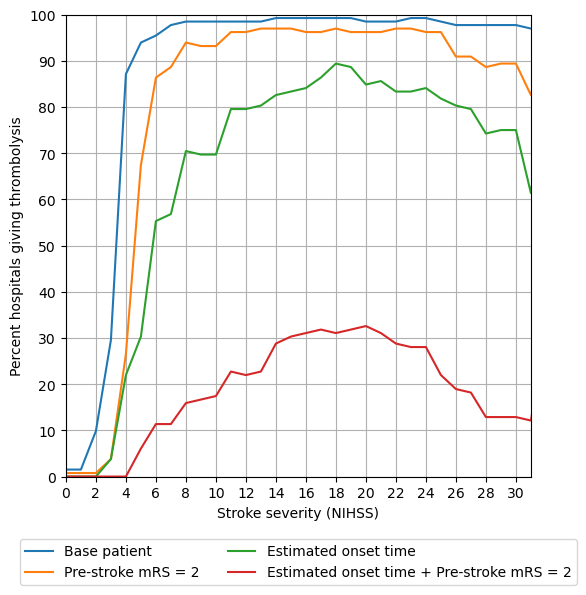

In [16]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = range(len(number_thrombolysing_NIHSS))

y1 = (np.array(control) / number_hopsitals) * 100
ax.plot(x, y1, label = 'Base patient')

y2 = (np.array(disability) / number_hopsitals) * 100
ax.plot(x, y2, label = 'Pre-stroke mRS = 2')

y3 = (np.array(estimated) / number_hopsitals) * 100
ax.plot(x, y3, label = 'Estimated onset time')

y4 = (np.array(disability_estimated) / number_hopsitals) * 100
ax.plot(x, y4, label = 'Estimated onset time + Pre-stroke mRS = 2')


ax.set_xlabel('Stroke severity (NIHSS)')
ax.set_ylabel('Percent hospitals giving thrombolysis')
ax.set_xticks(np.arange(0,31,2))
ax.set_yticks(np.arange(0,101,10))
ax.set_ylim(0,100)
ax.set_xlim(0,31)
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
    fancybox=True, shadow=False, ncol=2)

plt.savefig('./output/synthetic_patient_interactions.jpg', dpi=300)
plt.show()

## Observations

* There are interactions between features in the number of hopsitals that would give patients thrombolysis.
* Changing three features individually (stroke severity NIHSS=5, pre-stroke disablity =2, estimated stroke onset) have minor effects alone, but when combined only 8 out of 132 hopsitals (6.2%) are predicted to give thrombolysis to that patient.